# Calculate PCA data using the Ag3 data release

The PCA data files for gamb_colu, arab and gamb_colu_arab are stored on Google Cloud Storage. Each Zarr is about 5 MB.

A few basic plots are made to eyeball the data before it is stored.

In [1]:
# Imports
import gcsfs
import pandas as pd
import zarr
import allel
import numpy as np
import matplotlib.pyplot as plt

## Settings

In [2]:
# Specify the species groups, used in file names, site filter, region and sample selection
species_groups = ['gamb_colu_arab', 'gamb_colu','arab']

# The number of principal components to process
n_principal_components = 10

# Specify the storage paths
input_alleles_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_umap_input_alleles.zarr'
output_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'

## Check the output doesn't already exist

In [3]:
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# Check that the output's Zarr metadata file is not already on the cloud.
# We don't want to accidentally overwrite or delete existing data, which might have been used in downstream analysis.
# We don't simply check for the existence of the Zarr file here (i.e. output_cloud_zarr_path),
# We might want to re-run the first parts of this notebook again,
# so the Zarr store might legitimately exist but be incomplete.
# The Zarr store is not considered complete until the Zarr metadata file (.zmetadata) is present and correct.
# The final part of this notebook includes steps to create the Zarr metadata file and then validate it.

for species_group in species_groups:
    output_cloud_zarr_path = output_cloud_zarr_path_template.format(species_group)
    output_cloud_zarr_metadata_path = f'{output_cloud_zarr_path}/.zmetadata'
    assert not auth_fs.exists(output_cloud_zarr_metadata_path)

## Get the allele counts for each species group

In [4]:
allele_count_zarr_stores = {} # Not used, but kept for convenience
allele_count_zarr_groups = {}
for species_group in species_groups:
    allele_count_zarr_stores[species_group] = auth_fs.get_mapper(input_alleles_cloud_zarr_path_template.format(species_group))
    allele_count_zarr_groups[species_group] = zarr.Group(allele_count_zarr_stores[species_group], read_only=True)

## Run the PCA

In [5]:
# NOTE: if this halts with `ValueError: array must not contain infs or NaNs`
# that might be because we've selected a non-segregating variant, where division leads to inf.

In [6]:
%%time
pca_data = {}
for species_group in species_groups:
    print(species_group)
    computed_downsampled_allele_counts = allele_count_zarr_groups[species_group]['allele_counts_pca_ready']
    pca_data[species_group] = {}
    pca_data[species_group]['coords'], pca_data[species_group]['model'] = allel.pca(computed_downsampled_allele_counts, n_components=n_principal_components, scaler='patterson')
# Wall time: 3min 29s

gamb_colu_arab
gamb_colu
arab
CPU times: user 11min 41s, sys: 17.9 s, total: 11min 58s
Wall time: 4min 21s


In [7]:
# Eyeball the coordinates data
for species_group in species_groups:
    print(pca_data[species_group]['coords'])

[[-2.3193724e+01  1.5666333e+00 -6.6000457e+00 ...  5.0364232e-01
   2.3153803e+00 -1.4496237e+00]
 [-2.2138273e+01  3.8411682e+00 -5.6490808e+00 ... -2.9272822e-01
   2.0537508e+00 -3.0262733e+00]
 [-2.0418766e+01  3.0247428e+00 -4.0343060e+00 ... -8.6849117e-01
   4.1160937e-03 -4.6435249e-01]
 ...
 [-2.3232772e+00  2.6157904e+01 -7.3260558e-01 ...  1.5746340e+00
  -6.3854938e+00  2.7584834e+00]
 [-4.5826845e+00  2.6332535e+01 -1.6653723e-01 ...  9.0633554e+00
  -2.2325702e+00  1.8209909e+00]
 [-3.8428502e+00  2.1192047e+01  4.3393445e+00 ...  2.2596951e+00
   2.4119113e-01  3.1847432e-01]]
[[ -16.402231     -8.965208   -129.69632    ...   -0.74392223
     1.2441988    -1.7192483 ]
 [ -17.322542     -8.071077   -134.26373    ...   -0.7536079
     1.1914291    -0.53682446]
 [ -15.927236     -7.412089   -129.6818     ...    0.6928197
     0.85468674   -0.22170635]
 ...
 [  29.168945      6.6281834     3.7553194  ...    2.3818493
    23.32599      32.466694  ]
 [  27.560432      6.12472

In [8]:
# Eyeball the explained variance ratios
for species_group in species_groups:
    print(pca_data[species_group]['model'].explained_variance_ratio_)

[0.00637726 0.00378944 0.00289435 0.0027758  0.00182301 0.00158694
 0.00143017 0.00115849 0.00100931 0.00100155]
[0.00498083 0.00361252 0.00321538 0.00226845 0.00193543 0.00165843
 0.00145673 0.00114599 0.0011173  0.00107434]
[0.010099   0.00586918 0.00473376 0.00452302 0.00445473 0.00441078
 0.00425282 0.00408537 0.00404398 0.00401485]


## Avoid the component orientations flipping randomly when re-run

In [9]:
%%time
for species_group in species_groups:
    
    coords = pca_data[species_group]['coords']
    components = pca_data[species_group]['model'].components_
    allele_counts = allele_count_zarr_groups[species_group]['allele_counts_pca_ready']
    
    # To avoid the component orientations flipping randomly when re-run,
    # choose the maximum absolute value for the coords to be positive
    do_inv = []
    for n_pc in range(0, len(components)):
        mx = np.max(coords[:, n_pc])
        mn = np.min(coords[:, n_pc])
        if mx >= -mn:
            do_inv.append(1)
        else:
            do_inv.append(-1)
            
    pca_data[species_group]['polarized_coords'] = np.ndarray(shape=(len(coords), len(components)))
    for n_pc in range(0, len(components)):
        for n_s in range(0, len(coords)):
            pca_data[species_group]['polarized_coords'][n_s, n_pc] = coords[n_s, n_pc] * do_inv[n_pc]
            
    pca_data[species_group]['polarized_components'] = np.ndarray(shape=(len(components), allele_counts.shape[0]))
    for n_pc in range(0, len(pca_data[species_group]['model'].components_)):
        for n_ds in range(0, allele_counts.shape[0]):
            pca_data[species_group]['polarized_components'][n_pc, n_ds] = components[n_pc, n_ds] * do_inv[n_pc]
# Wall time: 3.2 s

CPU times: user 7.22 s, sys: 26.2 ms, total: 7.25 s
Wall time: 7.56 s


## Eyeball a couple of basic PCA plots

### Matplotlib

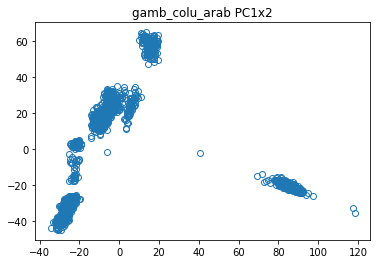

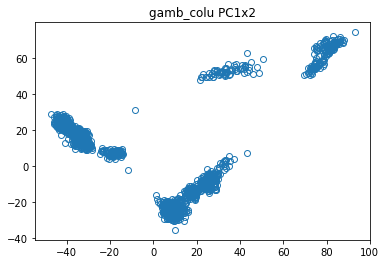

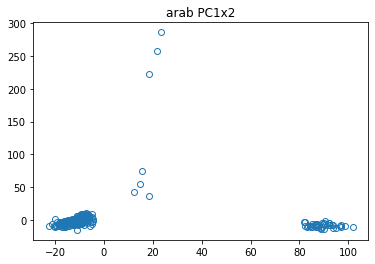

In [10]:
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    fig, ax = plt.subplots()
    ax.plot(polarized_coords[:, 0], polarized_coords[:, 1], marker='o', linestyle=' ', markerfacecolor='none')
    ax.set_title(f'{species_group} PC1x2')

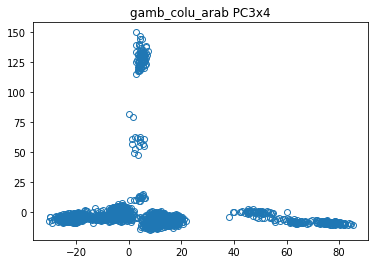

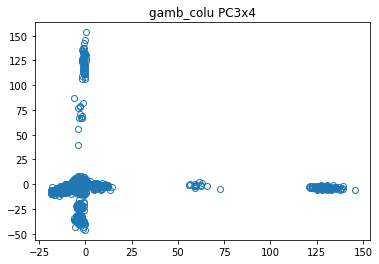

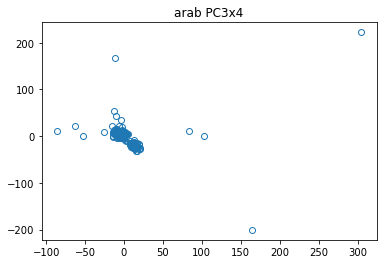

In [11]:
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    fig, ax = plt.subplots()
    ax.plot(polarized_coords[:, 2], polarized_coords[:, 3], marker='o', linestyle=' ', markerfacecolor='none')
    ax.set_title(f'{species_group} PC3x4')

## Eyeball the explained variance ratio per component

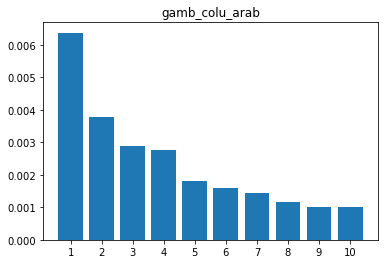

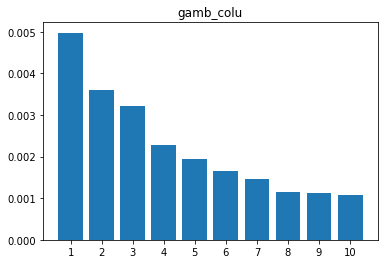

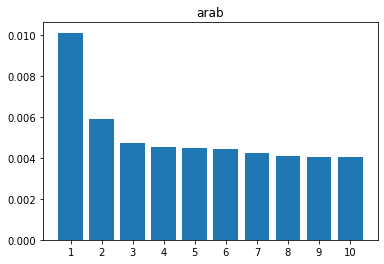

In [12]:
for species_group in species_groups:
    model = pca_data[species_group]['model']
    plt.figure(species_group)
    plt.title(species_group)
    plt.bar(range(n_principal_components), model.explained_variance_ratio_, tick_label=range(1, n_principal_components + 1))

## Store the PCA data

In [13]:
# Check the data types
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    model = pca_data[species_group]['model']
    print(species_group, type(polarized_coords), type(model.explained_variance_ratio_))

gamb_colu_arab <class 'numpy.ndarray'> <class 'numpy.ndarray'>
gamb_colu <class 'numpy.ndarray'> <class 'numpy.ndarray'>
arab <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [14]:
pca_zarr_stores = {}
pca_zarr_groups = {}
for species_group in species_groups:

    output_cloud_zarr_path = output_cloud_zarr_path_template.format(species_group)
    print('Will attempt to store at:', output_cloud_zarr_path)

    # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
    # Keep the pca_zarr_store for zarr.consolidate_metadata(pca_zarr_store)
    pca_zarr_stores[species_group] = auth_fs.get_mapper(output_cloud_zarr_path)
    pca_zarr_groups[species_group] = zarr.group(pca_zarr_stores[species_group])

Will attempt to store at: vo_agam_production/ag3_data_paper/gamb_colu_arab.pca_output.zarr
Will attempt to store at: vo_agam_production/ag3_data_paper/gamb_colu.pca_output.zarr
Will attempt to store at: vo_agam_production/ag3_data_paper/arab.pca_output.zarr


In [15]:
%%time
for species_group in species_groups:
    pca_zarr_group = pca_zarr_groups[species_group]
    polarized_coords = pca_data[species_group]['polarized_coords']
    model = pca_data[species_group]['model']
    sample_names = allele_count_zarr_groups[species_group]['sample_names']
    polarized_components = pca_data[species_group]['polarized_components']
    
    pca_zarr_group.create_dataset("coords", data=polarized_coords, overwrite=True) # overwrite otherwise `ValueError: path 'coords' contains an array`
    pca_zarr_group.create_dataset("explained_variance_ratio", data=model.explained_variance_ratio_, overwrite=True)
    pca_zarr_group.create_dataset("sample_names", data=sample_names, overwrite=True)
    pca_zarr_group.create_dataset("components", data=polarized_components, overwrite=True)
    # pca_zarr_group.create_dataset("downsampled_site_indices", data=downsampled_site_indices, overwrite=True)
# Wall time: 10.8 s

CPU times: user 789 ms, sys: 41.2 ms, total: 830 ms
Wall time: 13.2 s


## Check the stored PCA data

In [16]:
%%time
# Check all chunks are initialized
for species_group in species_groups:
    pca_zarr_group = pca_zarr_groups[species_group]
    
    assert pca_zarr_group['coords'].nchunks_initialized == pca_zarr_group['coords'].nchunks
    assert pca_zarr_group['explained_variance_ratio'].nchunks_initialized == pca_zarr_group['explained_variance_ratio'].nchunks
    assert pca_zarr_group['sample_names'].nchunks_initialized == pca_zarr_group['sample_names'].nchunks
    assert pca_zarr_group['components'].nchunks_initialized == pca_zarr_group['components'].nchunks
    #assert pca_zarr_group['downsampled_site_indices'].nchunks_initialized == pca_zarr_group['downsampled_site_indices'].nchunks
# Wall time: 1.83 s

CPU times: user 97.4 ms, sys: 8.04 ms, total: 105 ms
Wall time: 1.96 s


In [17]:
# Check that the pca_zarr_store contains the expected arrays
for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]
    
    assert 'coords/.zarray' in pca_zarr_store
    assert 'explained_variance_ratio/.zarray' in pca_zarr_store
    assert 'sample_names/.zarray' in pca_zarr_store
    assert 'components/.zarray' in pca_zarr_store
    #assert 'downsampled_site_indices/.zarray' in pca_zarr_store

## Consolidate the Zarr metadata

In [18]:
# Consolidate the metadata
# https://zarr.readthedocs.io/en/stable/api/convenience.html#zarr.convenience.consolidate_metadata
# "Consolidate all metadata for groups and arrays within the given store into a single resource and put it under the given key."
# "This produces a single object in the backend store, containing all the metadata read from all the zarr-related keys that can be found."

for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]
    zarr.consolidate_metadata(pca_zarr_store)

## Check the consolidated Zarr metadata

In [19]:
for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]

    # Re-load the consolidated metadata, for validation
    pca_zarr_consolidated_metadata = zarr.open_consolidated(pca_zarr_store)
    
    # Test that the keys of the consolidated metadata are as expected 
    # REM: 'downsampled_site_indices', 
    assert list(pca_zarr_consolidated_metadata.keys()) == ['components', 'coords', 'explained_variance_ratio', 'sample_names']